In [31]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy

In [32]:
# initialization for data set and device
data = pd.read_csv('diabetes.txt', sep='\t', header=None).values[:, 1:]
# print(torch.cuda.get_device_name(0))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
dtype = torch.cuda.FloatTensor
print(data.shape)

(768, 10)


In [33]:
X_NUM = 8
Y_NUM = 2

BATCH_SIZE = 300
LR = 1e-2
EPOCH = 2000
TRAIN_SIZE = 600
HIDDEN = [10, 10]
loss_hist = []
val_acc_hist = []
LR_DECAY = 1e-2

In [34]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.data=dataset
    def __getitem__(self, index):
        return self.data[index,:-Y_NUM], self.data[index,-Y_NUM:]
    def __len__(self):
        return self.data.shape[0]

In [35]:
# Validation set for tunning
train_set = MyDataset(data[:500])
val_set = MyDataset(data[500:TRAIN_SIZE])
test_set =  MyDataset(data[TRAIN_SIZE:])
train_loader = torch.utils.data.DataLoader(dataset = train_set, batch_size = BATCH_SIZE, shuffle = True)
val_loader = torch.utils.data.DataLoader(dataset = val_set, batch_size = BATCH_SIZE, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_set, batch_size = BATCH_SIZE, shuffle=False)

In [36]:
class NeuralNet(nn.Module):
    def __init__(self, layer_sizes):
        super(NeuralNet, self).__init__()
        layers = []
        for i in range(len(layer_sizes)-1):
            layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1], bias=True))
            layers.append(nn.Sigmoid()) 
        self.num_layers = len(layer_sizes) - 2
        self.model = nn.Sequential(*layers)
    def forward(self, x):
        return self.model(x)

In [37]:
def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR divided by 5 at 50th, 100th and 140th epochs"""
    lr_tmp = LR * (0.2 ** int(epoch >= 50))

    for param_group in optimizer.param_groups:
        param_group["lr"] = lr_tmp


In [38]:
%%time
model = NeuralNet([X_NUM]+HIDDEN+[Y_NUM]).to(device).double()
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
total_step = len(train_loader)
lr = LR
best_loss = 10000000
best_model = None
for epoch in range(EPOCH):
    for i, (datas, labels) in enumerate(train_loader):
        lr = adjust_learning_rate(optimizer, epoch)
        datas = datas.to(device)
        labels = labels.to(device)
        out = model(datas)
        loss = criterion(out, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if(epoch+1)%10==0 and i==0:
               print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Lr:{}'
               .format(epoch+1, EPOCH, i+1, total_step, loss.item(), lr))
    if loss.item() < best_loss:
        best_loss = loss.item()
        best_model = copy.deepcopy(model)
    loss_hist.append(loss.item())
    with torch.no_grad():
        correct = 0
        total = 0
        for datas, labels in val_loader:
            datas = datas.to(device)
            labels = labels.to(device).long()
            out = best_model(datas)
            _, predicted = torch.max(out.data, 1)
            total += labels.size(0)
            _, labels = torch.max(labels, 1)
            correct += (torch.eq(predicted,labels)).sum().item()
        val_acc_hist.append(correct/total)

Epoch [10/2000], Step [1/2], Loss: 0.2594, Lr:None
Epoch [20/2000], Step [1/2], Loss: 0.2570, Lr:None
Epoch [30/2000], Step [1/2], Loss: 0.2540, Lr:None
Epoch [40/2000], Step [1/2], Loss: 0.2507, Lr:None
Epoch [50/2000], Step [1/2], Loss: 0.2471, Lr:None
Epoch [60/2000], Step [1/2], Loss: 0.2482, Lr:None
Epoch [70/2000], Step [1/2], Loss: 0.2480, Lr:None
Epoch [80/2000], Step [1/2], Loss: 0.2458, Lr:None
Epoch [90/2000], Step [1/2], Loss: 0.2465, Lr:None
Epoch [100/2000], Step [1/2], Loss: 0.2458, Lr:None
Epoch [110/2000], Step [1/2], Loss: 0.2475, Lr:None
Epoch [120/2000], Step [1/2], Loss: 0.2472, Lr:None
Epoch [130/2000], Step [1/2], Loss: 0.2476, Lr:None
Epoch [140/2000], Step [1/2], Loss: 0.2434, Lr:None
Epoch [150/2000], Step [1/2], Loss: 0.2448, Lr:None
Epoch [160/2000], Step [1/2], Loss: 0.2425, Lr:None
Epoch [170/2000], Step [1/2], Loss: 0.2414, Lr:None
Epoch [180/2000], Step [1/2], Loss: 0.2426, Lr:None
Epoch [190/2000], Step [1/2], Loss: 0.2420, Lr:None
Epoch [200/2000], Ste

Epoch [1580/2000], Step [1/2], Loss: 0.2238, Lr:None
Epoch [1590/2000], Step [1/2], Loss: 0.2298, Lr:None
Epoch [1600/2000], Step [1/2], Loss: 0.2203, Lr:None
Epoch [1610/2000], Step [1/2], Loss: 0.2246, Lr:None
Epoch [1620/2000], Step [1/2], Loss: 0.2263, Lr:None
Epoch [1630/2000], Step [1/2], Loss: 0.2211, Lr:None
Epoch [1640/2000], Step [1/2], Loss: 0.2211, Lr:None
Epoch [1650/2000], Step [1/2], Loss: 0.2280, Lr:None
Epoch [1660/2000], Step [1/2], Loss: 0.2280, Lr:None
Epoch [1670/2000], Step [1/2], Loss: 0.2192, Lr:None
Epoch [1680/2000], Step [1/2], Loss: 0.2253, Lr:None
Epoch [1690/2000], Step [1/2], Loss: 0.2297, Lr:None
Epoch [1700/2000], Step [1/2], Loss: 0.2288, Lr:None
Epoch [1710/2000], Step [1/2], Loss: 0.2341, Lr:None
Epoch [1720/2000], Step [1/2], Loss: 0.2235, Lr:None
Epoch [1730/2000], Step [1/2], Loss: 0.2305, Lr:None
Epoch [1740/2000], Step [1/2], Loss: 0.2235, Lr:None
Epoch [1750/2000], Step [1/2], Loss: 0.2199, Lr:None
Epoch [1760/2000], Step [1/2], Loss: 0.2270, L

0.20331577275125906


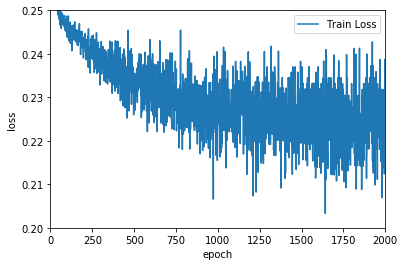

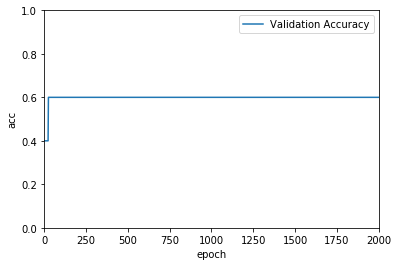

In [39]:
print(best_loss)
plt.plot(loss_hist, label='Train Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.axis([0, EPOCH, 0.2, 0.25])
plt.legend()

plt.show()

plt.plot(val_acc_hist, label='Validation Accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.axis([0, EPOCH, 0, 1])
plt.legend()

plt.show()

In [40]:

with torch.no_grad():
    correct = 0
    total = 0
    for datas, labels in test_loader:
        datas = datas.to(device)
        labels = labels.to(device).long()
        out = best_model(datas)
        _, predicted = torch.max(out.data, 1)
        total += labels.size(0)
        _, labels = torch.max(labels, 1)
        correct += (torch.eq(predicted,labels)).sum().item()
    print(correct)
    print('Accuracy of the network on the {} test records: {} %'.format(data.shape[0]-TRAIN_SIZE, 100.0 * correct / total))

109
Accuracy of the network on the 168 test records: 64.88095238095238 %
